In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
maindir = "/content/drive/MyDrive/Blood ai classification challenge" # Directory with your files
traincsv = maindir+"/Train.csv"
testcsv = maindir+"/Test.csv"

In [4]:
train = pd.read_csv(traincsv)
train.head()

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ID_3SSHI56C,0.479669,0.477423,0.487956,0.491831,0.500516,0.502590,0.511561,0.514639,0.524245,0.536170,0.546407,0.561557,0.568417,0.571877,0.570884,0.569032,0.567476,0.565662,0.561901,0.559722,0.557474,0.554371,0.552386,0.548702,0.544238,0.542579,0.540514,0.538980,0.536650,0.536483,0.535447,0.537577,0.535715,0.536895,0.539589,0.541081,0.544893,0.547765,0.551773,...,1.469838,1.462617,1.445696,1.435586,1.417847,1.404205,1.388861,1.377436,1.364444,1.360373,1.341243,1.339632,1.321471,1.317444,1.311209,1.291677,1.285579,1.285488,1.275784,1.271104,1.264029,1.250779,1.254856,1.255224,1.249623,1.244419,1.244437,1.243933,1.226790,1.234055,1.218660,1.213038,1.198317,1.195735,1.180846,42.51,34.01,ok,ok,ok
1,ID_599OOLZA,0.471537,0.474113,0.479981,0.485528,0.491049,0.497942,0.504760,0.510543,0.522328,0.534423,0.548646,0.558420,0.565449,0.569717,0.570999,0.569969,0.568405,0.566628,0.564101,0.559951,0.556193,0.552271,0.550086,0.546207,0.542366,0.539789,0.537221,0.534336,0.533868,0.533018,0.532227,0.530818,0.532171,0.533658,0.535266,0.538939,0.542399,0.546479,0.550606,...,1.552979,1.541997,1.533186,1.518359,1.498964,1.488043,1.472946,1.465925,1.452647,1.437819,1.423670,1.415103,1.401141,1.403560,1.384169,1.379410,1.374128,1.356969,1.352693,1.342430,1.339714,1.332805,1.336324,1.342537,1.332407,1.326258,1.336874,1.327538,1.311951,1.309399,1.304501,1.323005,1.305992,1.263887,1.262095,44.52,32.09,ok,high,high
2,ID_MVJGPQ75,0.444998,0.458034,0.447386,0.456921,0.463225,0.475983,0.476817,0.481565,0.490010,0.505892,0.518125,0.530362,0.538530,0.543128,0.546287,0.547001,0.547120,0.546351,0.544254,0.542802,0.542207,0.539779,0.536417,0.533380,0.531117,0.529093,0.526101,0.524599,0.522952,0.521551,0.521149,0.520478,0.521432,0.521473,0.523567,0.525816,0.527889,0.530697,0.533416,...,1.516723,1.502255,1.489132,1.483308,1.461028,1.453174,1.450412,1.437784,1.422148,1.415880,1.404698,1.388143,1.397241,1.385680,1.376355,1.357758,1.354854,1.345476,1.333810,1.332739,1.335550,1.326775,1.336862,1.316860,1.328051,1.328641,1.323526,1.314124,1.298936,1.289122,1.325059,1.271115,1.337119,1.289877,1.345229,45.77,24.80,ok,ok,high
3,ID_CK6RF8YV,0.513434,0.513303,0.522609,0.521068,0.523146,0.530132,0.539517,0.546364,0.552414,0.565502,0.581143,0.594354,0.599457,0.604529,0.605267,0.606276,0.604895,0.603716,0.600683,0.598087,0.594303,0.589403,0.585883,0.581369,0.578962,0.575181,0.573274,0.570471,0.568241,0.565671,0.564579,0.563724,0.561978,0.562744,0.563455,0.565163,0.566505,0.569239,0.572075,...,1.442957,1.423349,1.413718,1.403112,1.393964,1.375741,1.369549,1.354179,1.344562,1.333491,1.325002,1.321572,1.305561,1.292637,1.287971,1.283460,1.278300,1.268486,1.268407,1.263479,1.252612,1.254306,1.247635,1.242321,1.247859,1.246749,1.249920,1.265223,1.264013,1.285252,1.298422,1.299873,1.311157,1.303259,1.349833,45.84,36.93,low,ok,high
4,ID_82N6QE6I,0.510485,0.519359,0.524225,0.528419,0.535273,0.545342,0.550314,0.55

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


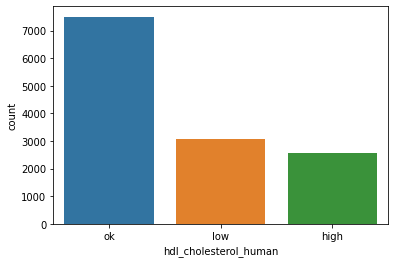

In [5]:
sns.countplot(train["hdl_cholesterol_human"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


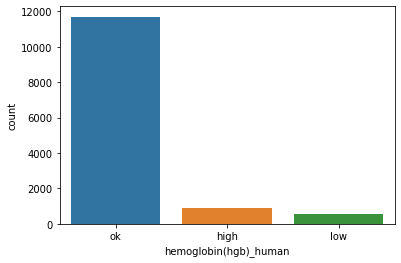

In [6]:
sns.countplot(train["hemoglobin(hgb)_human"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


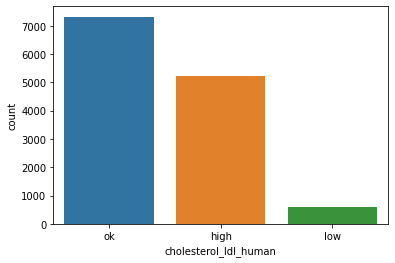

In [7]:
sns.countplot(train["cholesterol_ldl_human"])

In [8]:
train.drop(["Reading_ID"], axis=1, inplace=True)
#data = train.to_numpy()
 # 219 IDs

In [9]:
#features = np.array(data[:,:172], dtype=float)
#labels = data[:, 172:]

In [10]:
test = pd.read_csv(testcsv)
test.head()

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,absorbance9,absorbance10,absorbance11,absorbance12,absorbance13,absorbance14,absorbance15,absorbance16,absorbance17,absorbance18,absorbance19,absorbance20,absorbance21,absorbance22,absorbance23,absorbance24,absorbance25,absorbance26,absorbance27,absorbance28,absorbance29,absorbance30,absorbance31,absorbance32,absorbance33,absorbance34,absorbance35,absorbance36,absorbance37,absorbance38,...,absorbance132,absorbance133,absorbance134,absorbance135,absorbance136,absorbance137,absorbance138,absorbance139,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,absorbance148,absorbance149,absorbance150,absorbance151,absorbance152,absorbance153,absorbance154,absorbance155,absorbance156,absorbance157,absorbance158,absorbance159,absorbance160,absorbance161,absorbance162,absorbance163,absorbance164,absorbance165,absorbance166,absorbance167,absorbance168,absorbance169,temperature,humidity
0,ID_37BEI22R,0.449736,0.449798,0.447488,0.464694,0.466377,0.485350,0.488915,0.495073,0.504129,0.512690,0.528313,0.540020,0.550252,0.555062,0.555983,0.562491,0.559443,0.562695,0.558805,0.559067,0.557602,0.554924,0.553300,0.549671,0.548033,0.544539,0.542640,0.541228,0.540335,0.539378,0.539134,0.538375,0.538068,0.540340,0.541754,0.543920,0.547749,0.550490,0.553550,...,1.393886,1.389147,1.385912,1.377751,1.372950,1.366470,1.360301,1.351162,1.346405,1.350380,1.340395,1.326046,1.324390,1.322257,1.314661,1.308962,1.308751,1.298821,1.285794,1.294162,1.286025,1.288414,1.287432,1.266873,1.272191,1.270802,1.263687,1.252631,1.248400,1.249067,1.223793,1.195193,1.205222,1.164610,1.151594,1.166565,1.157079,1.200857,40.88,25.70
1,ID_4W85V5DV,0.495429,0.505488,0.510239,0.518880,0.533147,0.543142,0.551670,0.558261,0.564027,0.575223,0.588780,0.603260,0.609797,0.613326,0.616530,0.617400,0.617284,0.615343,0.611668,0.608864,0.606411,0.602919,0.599854,0.597024,0.592800,0.590059,0.586417,0.585922,0.583848,0.583204,0.582259,0.581994,0.582528,0.584993,0.587332,0.590686,0.591674,0.595796,0.599694,...,1.563284,1.553378,1.538660,1.524748,1.508455,1.495151,1.494071,1.476984,1.459555,1.449668,1.444659,1.432336,1.425302,1.407856,1.404927,1.400641,1.385942,1.380131,1.367970,1.367653,1.364312,1.357998,1.348350,1.346009,1.330666,1.334532,1.335588,1.315017,1.319510,1.320977,1.310219,1.294600,1.269705,1.244257,1.238365,1.218063,1.252711,1.255433,42.35,30.16
2,ID_L4YR3NDY,0.437904,0.439064,0.442527,0.450437,0.455363,0.465817,0.471249,0.479145,0.482595,0.497043,0.508849,0.520005,0.526073,0.529009,0.530775,0.530869,0.529993,0.529816,0.525386,0.522270,0.518925,0.516824,0.514363,0.510227,0.506540,0.503605,0.501884,0.499315,0.498547,0.497386,0.496028,0.495754,0.495847,0.495887,0.497499,0.499683,0.501803,0.504862,0.508623,...,1.411109,1.392950,1.382620,1.359417,1.348743,1.334049,1.325644,1.307332,1.295699,1.284021,1.276139,1.262930,1.252719,1.237859,1.231942,1.223501,1.213700,1.206026,1.197681,1.197900,1.196079,1.185196,1.175500,1.169110,1.165897,1.165072,1.167966,1.156225,1.156836,1.158974,1.162556,1.161711,1.160406,1.159570,1.159641,1.157491,1.177478,1.169607,42.83,25.51
3,ID_U88E3SQ6,0.495038,0.506246,0.508730,0.518995,0.529961,0.537583,0.539696,0.540400,0.547279,0.561166,0.572493,0.583802,0.588819,0.591780,0.596486,0.595962,0.595182,0.588548,0.584253,0.579974,0.576841,0.573102,0.569567,0.565961,0.563061,0.560563,0.556971,0.555630,0.554065,0.554014,0.552711,0.552815,0.552691,0.555071,0.557024,0.558817,0.563014,0.566382,0.571307,...,1.398357,1.390639,1.384277,1.367990,1.358839,1.353192,1.342092,1.332669,1.323776,1.316251,1.305992,1.291256,1.288653,1.275216,1.272748,1.262883,1.255950,1.249526,1.244164,1.232735,1.228173,1.214810,1.219419,1.212290,1.208059,1.203898,1.200965,1.200299,1.195953,1.179682,1.168321,1.137272,1.109380,1.047561,1.050649,1.020026,1.033139,1.023882,40.95,41.32
4,ID_NW7Z3XU7,0.531306,0.525309,0.535306,0

In [11]:
# save it ids before dropping them
idx = test.Reading_ID.values
test.drop(["Reading_ID"], axis=1, inplace=True)
#testdata = test.to_numpy()

In [12]:
target = ['cholesterol_ldl_human', 'hemoglobin(hgb)_human', 'hdl_cholesterol_human']
y = train[target]
y_data = train[target]
X = train.drop(['cholesterol_ldl_human', 'hemoglobin(hgb)_human', 'hdl_cholesterol_human'], axis =1)
X_test = test
y.shape, X.shape, X_test.shape

((13140, 3), (13140, 172), (3660, 172))

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state= 0, test_size= 0.2)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((10512, 172), (2628, 172), (10512, 3), (2628, 3))

In [146]:
from sklearn.ensemble import RandomForestClassifier
model = MultiOutputClassifier(RandomForestClassifier(n_estimators= 100, max_depth=3)).fit(X_train, y_train)
print(model.score(X_train, y_train))

0.3438926940639269


In [130]:
y_pred = model.predict(X_val)
print(model.score(X_val, y_val))

0.3066971080669711


In [131]:
def mymodel(features):
    output = model.predict(features)
    return output 

In [132]:
predictions = mymodel(X_test)
#Save the results to csv
ss = pd.DataFrame()
ss["Reading_ID"] = idx # don't messed up the ids. save them before.
ss["hdl_cholesterol_human"] = predictions[:,0]
ss["hemoglobin(hgb)_human"] = predictions[:,1]
ss["cholesterol_ldl_human"] = predictions[:,2]



In [133]:
def transform_c_hdl(row):
    return str(row["Reading_ID"]) + "_hdl_cholesterol_human" + "-" +  row["hdl_cholesterol_human"]

In [134]:
hdl_rows = pd.DataFrame(ss.apply(transform_c_hdl, axis=1))

In [135]:
def transform_hemo(row):
    return str(row["Reading_ID"]) + "_hemoglobin(hgb)_human" +  "-" + row["hemoglobin(hgb)_human"]

In [136]:
hemo_rows = pd.DataFrame(ss.apply(transform_hemo, axis=1))

In [137]:
def transform_c_ldl(row):
    return str(row["Reading_ID"]) + "_cholesterol_ldl_human" +  "-" + row["cholesterol_ldl_human"]

In [138]:
ldl_rows = pd.DataFrame(ss.apply(transform_c_ldl, axis=1))

In [139]:
ss = pd.concat([hdl_rows, hemo_rows, ldl_rows]).reset_index(drop=True)

In [140]:
ss["target"] = ss[0].apply(lambda x: x.split("-")[1])
ss[0] = ss[0].apply(lambda x: x.split("-")[0])

In [141]:
ss = ss.rename(columns={0:"Reading_ID"})

In [142]:
ss = ss.rename(columns={0:"Reading_ID"})

In [143]:
ss.head()

,Reading_ID,target
0,ID_37BEI22R_hdl_cholesterol_human,high
1,ID_4W85V5DV_hdl_cholesterol_human,ok
2,ID_L4YR3NDY_hdl_cholesterol_human,ok
3,ID_U88E3SQ6_hdl_cholesterol_human,high
4,ID_NW7Z3XU7_hdl_cholesterol_human,ok


In [145]:
ss.to_csv(maindir+"/bloodai7.csv", index=False)